# OpenTopography Overview of RayShader Library

## Authors
Author1 = {"name": "Nathaniel Quinn", "affiliation": "UNAVCO, Inc.", "email": "nathaniel.quinn@unavco.org", "orcid":""}

## Purpose
This is an [R Markdown](http://rmarkdown.rstudio.com/) Notebook created by [OpenTopography](https://opentopography.org/) profiling the [RayShader](https://cran.r-project.org/web/packages/rayshader/rayshader.pdf) package. This package utilizes a combination of raytracing and multiple hill shading methods to produce 2D and 3D data visualizations and maps. A variety of options are explored in this tutorial, however, please see full package documentation as many more features are available.




## Technical Contributions
This notebook calls the [USGS 3DEPElevation Image Server](https://elevation.nationalmap.gov/arcgis/rest/services/3DEPElevation/ImageServer/exportImage) for lidar digital elevation models (DEMs) and [ArcGIS Rest Services Directory World_Imagery](https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer) for one meter satellite and aerial imagery. When selecting a region to visualize, note that these sources only support locations within the United States.

The notebook culminates in a 3D model of the specified area overlaid with the imagery from that location. This creates an accurate model in both form and color of the DEM.



## Funding
OpenTopography is supported by the National Science Foundation under Award Numbers 1948997, 1948994 & 1948857

## Acknowledgments
We want to thank the RayShader creator [Tyler Morgan-Wall](https://www.tylermw.com/) for the continued package maintainance. As noted before, there are a vast number of ways to use this package, this notebook is only designed to get users started. Please let us know if you have any comments or suggestions and [Happy RayShading!](https://cran.r-project.org/web/packages/rayshader/rayshader.pdf)

## Setup
If running this tutorial locally: set up a new conda environment and install R and its dependcies:

`conda create -n R -c conda-forge r r-irkernel r-essentials geos r-rgeos r-rgdal r-sf`

**Notes**: Code snippets between two hashtagged comment sections indicate an area that requires user input.

Load (or install if needed) the following libraries.

In [1]:
library(rayshader)
library(rayrender)
library(shiny)
library(leaflet)
library(leaflet.extras)
library(sf)
library(tiff)
library(httr)
library(glue)
library(jsonlite)
library(httr)
library(magick)

Linking to GEOS 3.9.1, GDAL 3.3.1, PROJ 8.0.1


Attaching package: ‘jsonlite’


The following object is masked from ‘package:shiny’:

    validate


Linking to ImageMagick 6.9.12.3
Enabled features: cairo, fontconfig, freetype, heic, lcms, pango, raw, rsvg, webp
Disabled features: fftw, ghostscript, x11



In [2]:
# ADD YOUR COORDINATES HERE
# e.g. Crested Butte, CO
xmin = -107.02263
ymin = 38.85976
xmax = -106.89835
ymax = 38.93458
# ADD YOUR COORDINATES HERE

bbox <- list(
  p1 = list(long = xmin, lat = ymin),
  p2 = list(long = xmax, lat = ymax)
)


leaflet() %>%
  addTiles() %>% 
  addRectangles(
    lng1 = bbox$p1$long, lat1 = bbox$p1$lat,
    lng2 = bbox$p2$long, lat2 = bbox$p2$lat,
    fillColor = "transparent"
  ) %>%
  fitBounds(
    lng1 = bbox$p1$long, lat1 = bbox$p1$lat,
    lng2 = bbox$p2$long, lat2 = bbox$p2$lat,
  )

HTML widgets cannot be represented in plain text (need html)

Make sure bounding box matches your area of interest in map above. If not, revise coordinates.

Create function to define image size and resolution of the raster image and 3DEP data download.

In [3]:
define_image_size <- function(bbox, major_dim = 400) {
  aspect_ratio <- abs((bbox$p1$long - bbox$p2$long) / (bbox$p1$lat - bbox$p2$lat))
  img_width <- ifelse(aspect_ratio > 1, major_dim, major_dim*aspect_ratio) %>% round()
  img_height <- ifelse(aspect_ratio < 1, major_dim, major_dim/aspect_ratio) %>% round()
  size_str <- paste(img_width, img_height, sep = ",")
  list(height = img_height, width = img_width, size = size_str)
}

Note: Increasing the longest dimension variable increases resolution but slows rendering time. It is dependent on the size of your bounding box, however, we recommend starting with 1000.

In [4]:
#ADD YOUR LONGEST DIMENSION HERE
long_dim = 2500
#ADD YOUR LONGEST DIMENSION HERE

image_size <- define_image_size(bbox, long_dim)

image_size

$height
[1] 1505

$width
[1] 2500

$size
[1] "2500,1505"

Call USGS 3DEP Elevation API with the following function.

In [5]:
get_usgs_elevation_data <- function(bbox, size = "5000,3829", file = NULL, 
                                    sr_bbox = 4326, sr_image = 4326) {
  require(httr)
  url <- parse_url("https://elevation.nationalmap.gov/arcgis/rest/services/3DEPElevation/ImageServer/exportImage")
  res <- GET(
    url, 
    query = list(
      bbox = paste(bbox$p1$long, bbox$p1$lat, bbox$p2$long, bbox$p2$lat,
                   sep = ","),
      bboxSR = sr_bbox,
      imageSR = sr_image,
      size = size,
      format = "tiff",
      pixelType = "F64",
      noDataInterpretation = "esriNoDataMatchAny",
      interpolation = "+RSP_BilinearInterpolation",
      f = "json"
    )
  )
  
  if (status_code(res) == 200) {
    body <- content(res, type = "application/json")
    # TODO - check that bbox values are correct
    # message(jsonlite::toJSON(body, auto_unbox = TRUE, pretty = TRUE))
    
    img_res <- GET(body$href)
    img_bin <- content(img_res, "raw")
    if (is.null(file)) 
      file <- tempfile("elev_matrix", fileext = ".tif")
    writeBin(img_bin, file)
    message(paste("image saved to file:", file))
  } else {
    warning(res)
  }
  invisible(file)
}

Call the API function and save the DEM .tif of the specified area to your working directory.

In [6]:
elev_file <- file.path("3DEP-elevation.tif")
get_usgs_elevation_data(bbox, size = image_size$size, file = elev_file,
                        sr_bbox = 4326, sr_image = 4326)

image saved to file: 3DEP-elevation.tif



Load the 3DEP data into raster format.

In [7]:
elev_img <- raster::raster(elev_file)
elevation_matrix <- matrix(
  raster::extract(elev_img, raster::extent(elev_img), buffer = 1000), 
  nrow = ncol(elev_img), ncol = nrow(elev_img)
)

Call the World_Imagery API with the following function.

In [8]:
get_arcgis_map_image <- function(bbox, map_type = "World_Imagery", file = NULL, 
                          width = 5000, height = 3829, sr_bbox = 4326) {
  require(httr)
  require(glue) 
  require(jsonlite)
  
  url <- parse_url("https://utility.arcgisonline.com/arcgis/rest/services/Utilities/PrintingTools/GPServer/Export%20Web%20Map%20Task/execute")
  
  # define JSON query parameter
  web_map_param <- list(
    baseMap = list(
      baseMapLayers = list(
        list(url = jsonlite::unbox(glue("https://services.arcgisonline.com/ArcGIS/rest/services/{map_type}/MapServer",
                                        map_type = map_type)))
      )
    ),
    exportOptions = list(
      outputSize = c(width, height)
    ),
    mapOptions = list(
      extent = list(
        spatialReference = list(wkid = jsonlite::unbox(sr_bbox)),
        xmax = jsonlite::unbox(max(bbox$p1$long, bbox$p2$long)),
        xmin = jsonlite::unbox(min(bbox$p1$long, bbox$p2$long)),
        ymax = jsonlite::unbox(max(bbox$p1$lat, bbox$p2$lat)),
        ymin = jsonlite::unbox(min(bbox$p1$lat, bbox$p2$lat))
      )
    )
  )
  
  res <- GET(
    url, 
    query = list(
      f = "json",
      Format = "PNG32",
      Layout_Template = "MAP_ONLY",
      Web_Map_as_JSON = jsonlite::toJSON(web_map_param))
  )
  
  if (status_code(res) == 200) {
    body <- content(res, type = "application/json")
    message(jsonlite::toJSON(body, auto_unbox = TRUE, pretty = TRUE))
    if (is.null(file)) 
      file <- tempfile("overlay_img", fileext = ".png")
    
    img_res <- GET(body$results[[1]]$value$url)
    img_bin <- content(img_res, "raw")
    writeBin(img_bin, file)
    message(paste("image saved to file:", file))
  } else {
    message(res)
  }
  invisible(file)
}

Call the API function and save the satellite and aerial imagery of the specified area to your working directory.

In [9]:
gis_overlay_file <- "map.png"
get_arcgis_map_image(bbox, map_type = "World_Imagery", file = gis_overlay_file,
                     width = image_size$width, height = image_size$height, 
                     sr_bbox = 4326)
overlay_img <- png::readPNG(gis_overlay_file)

{
  "results": [
    {
      "paramName": "Output_File",
      "dataType": "GPDataFile",
      "value": {
        "url": "https://utility.arcgisonline.com/arcgis/rest/directories/arcgisoutput/Utilities/PrintingTools_GPServer/x_____xY0jli5MmsEg5f7WaZjPkFg..x_____x_ags_c4406cc0-ef1d-11eb-8f6b-22000a63ebfa.png"
      }
    }
  ],
  "messages": []
}

image saved to file: map.png



Now we have all necessary data loaded to begin visualizing. RayShader includes a variety of different methods for visualization. In these two code examples, we create a 2D followed by a 3D visualization that overlays satellite imagery on the model.

The 2D image of a 3D model is produced below. Note: Some models appear more realistic with water detection, some without. Do a test depending on your needs. The alphalayer integer can be set between 0 and 1, and dictates transparency of overlay imagery. Recommend starting at 0.5 and adjusting from there, with higher values reducing transparency.

In [ ]:
elevation_matrix %>%
  sphere_shade(texture = "desert") %>%
  add_overlay(overlay_img, alphalayer = 0.5) %>%
  plot_map()

The next code snippet creates a 3Dimensional model of the specified area. This can be orbited for a variety of rendering views. Other attributes, such as shadow, water, overlay, are adjusted in similar manner as 2D graphic above.

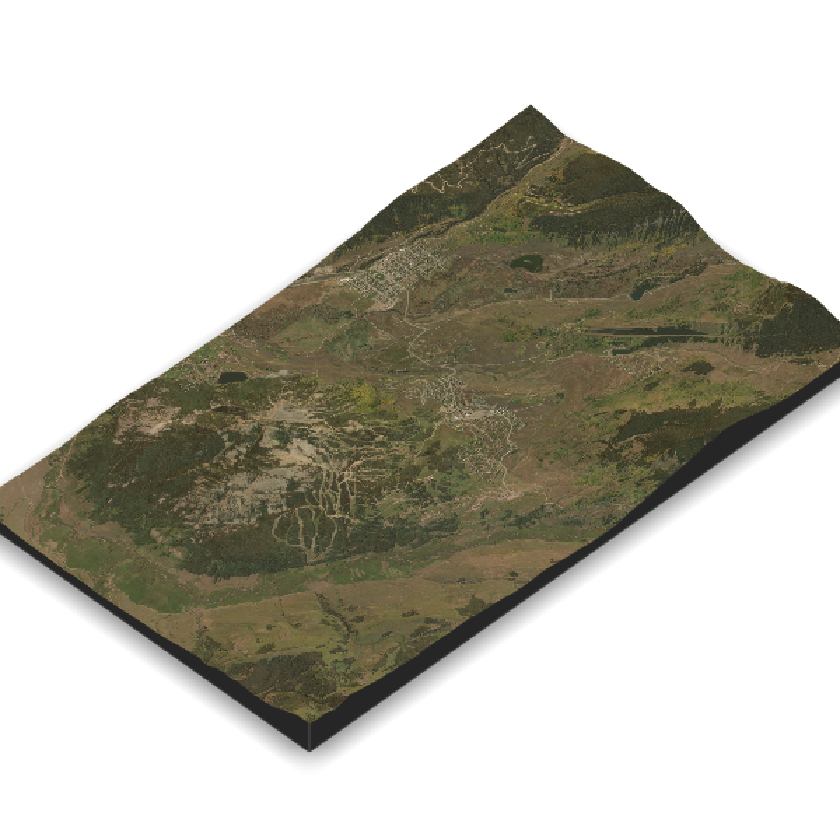

In [10]:
elevation_matrix %>%
  sphere_shade(texture ="desert") %>%
  add_overlay(overlay_img, alphalayer = 0.8) %>%
  plot_3d(elevation_matrix, zscale = 7, fov = 0, theta = 135, zoom = 0.8, phi = 45)
Sys.sleep(0.2)
render_snapshot()